In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack, stats
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

#### Functions

In [8]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [9]:
def get_responsive_pvalue(spike_times, spike_clusters, unit_ids, events, response_window=[0.002, 0.1], apply_mc_corr=True):
    wstat = np.zeros(len(unit_ids), dtype=float) * np.nan
    pvals = np.zeros(len(unit_ids), dtype=float) * np.nan
    
    for indi, uniti in enumerate(unit_ids):
        spikesi = np.squeeze(spike_times[spike_clusters == uniti])

        pre_spcounts = np.zeros(len(events), dtype=int)
        post_spcounts = np.zeros(len(events), dtype=int)
        for j, E in enumerate(events):
            pre_spcounts[j] = np.sum((spikesi >= E-response_window[1]) & (spikesi <= E-response_window[0]))
            post_spcounts[j] = np.sum((spikesi >= E+response_window[0]) & (spikesi <= E+response_window[1]))
        
#         if (post_spcounts - pre_spcounts).any():
            # stats.wilcoxon tests whether the differences x-y is symmetric about zero #
        wstat[indi], pvals[indi] = stats.wilcoxon(x=post_spcounts, y=pre_spcounts, zero_method='zsplit')
            # added zero-method as zsplit because many of the units have too few non-zero samples #
            # this includes the zeros in ranking, but splits them evenly between positive and negative difference ranks #
        
    if apply_mc_corr:
        print('Applying multiple comparisons correction...')
        rej, pvals = multitest.fdrcorrection(pvals)

    return pvals, wstat

### Define data path

In [10]:
rec_folder = r'F:\EEG_exp\mouse590480\estim_vis_2021-11-11_10-54-19\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [11]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

In [12]:
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

estim_vis


#### Load EEG data

In [13]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()

## Get bad_ch_list from metadata ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))

In [14]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

# bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

#### Load stim table and get good EEG channels

In [15]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,biphasic,30,318.77278,318.77318,0.0004,0,True
1,biphasic,30,322.64213,322.64253,0.0004,0,True
2,biphasic,50,326.60327,326.60367,0.0004,0,True
3,biphasic,70,331.08534,331.08574,0.0004,0,True
4,biphasic,70,334.74216,334.74256,0.0004,0,True


In [16]:
state_sweeps = {'awake': [0], 'anesthetized': [1]}#, 'recovery1': [2]}

#### Load unit data

In [18]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [19]:
## List probes: region labels in order from top to bottom ##
regions = {'probeF': 'ACA <-> MOs', 'probeB': 'VM <-> SSp', 'probeD': 'LGN <-> VIS'}
# regions = {'probeB': 'ACA <---> MOs'}#, 'probeC': 'V1/LGN'}
# regions = {'probeF': 'MOs', 'probeB': 'VM/VAL', 'probeD': 'V1/LGN'}

In [20]:
which_units = 'all' # can choose 'all', 'ctx'
FR_threshold = 0.5 # only chooses units with firing rate above this frequency, if None does not apply threshold

In [21]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    
    ## Apply firing rate threshold ##
    if FR_threshold != None:
        unit_metrics = unit_metrics[unit_metrics['firing_rate'] > FR_threshold]
        select_units = unit_metrics.cluster_id.values
        peak_chs = unit_metrics.peak_channel.values
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        if which_units == 'ctx':
            ## determine cortical units ##
            ctx_mask = np.zeros_like(all_units, dtype=bool)
            for uai, areai in enumerate(all_units_areas):
                if areai != 'null':
                    if 315 in str_tree.get_structures_by_acronym([areai])[0]['structure_id_path']:
                        ctx_mask[uai] = True
            probe_unit_data[probei]['units'] = all_units[ctx_mask]
            probe_unit_data[probei]['areas'] = all_units_areas[ctx_mask]
            probe_unit_data[probei]['chs'] = all_units_chs[ctx_mask]
            total_units += len(probe_unit_data[probei]['units'])
        else:
            probe_unit_data[probei]['units'] = all_units
            probe_unit_data[probei]['areas'] = all_units_areas
            probe_unit_data[probei]['chs'] = all_units_chs
            total_units += len(probe_unit_data[probei]['units'])
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
        probe_unit_data[probei]['units'] = all_units
        probe_unit_data[probei]['chs'] = all_units_chs
        total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 351
 unit count: 235
 unit metrics file does not have area assignments.
probeC
 surface channel: 350
 unit count: 268
 unit metrics file does not have area assignments.
probeF
 surface channel: 354
 unit count: 286
 unit metrics file does not have area assignments.
Total unit count: 789


### Plot some responses and quantify

In [22]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic', 'circle'
plamp = '35' # always a string now
plstate = 'awake'

before_event = 0.2 # time before event, s
after_event = 0.8 # time after event, s

## Unit params ##
plot_timebin = 0.005 # s

In [23]:
unit_rates = {}
unit_zscores = {}
unit_pvals = {}
unit_wstat = {}

state_events = []
for sweepi in state_sweeps[plstate]:
    events = get_stim_events(stim_log, stim_type, plamp, sweepi)
    if len(events) == 0:
        continue
    state_events.append(events)
state_events = np.concatenate(state_events)

## Get mean speed ##
rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
rest_events = np.nonzero(mean_speed < 0.5)[0]
print('{} state: resting trials {:d}/{:d}'.format(plstate, len(rest_events), len(state_events)))

# get evoked firing rates for all units
total_units = 0
for probei, unit_data in probe_unit_data.items():
    event_trig_FR, spikerate_ts = get_evoked_firing_rates(
        unit_data['spike_times'],
        unit_data['spike_clusters'],
        unit_data['units'],
        state_events[rest_events],
        before_event,
        after_event,
        plot_timebin
    )
    # get zscore
    event_trig_Z, non_nan_inds = get_zscore_fr(event_trig_FR, spikerate_ts)

    unit_rates[probei] = [spikerate_ts, event_trig_FR]
    unit_zscores[probei] = [spikerate_ts, event_trig_Z]
    total_units += event_trig_FR.shape[1]
    
    start = time.time()
    unit_pvals[probei], unit_wstat[probei] = get_responsive_pvalue(
        unit_data['spike_times'],
        unit_data['spike_clusters'],
        unit_data['units'],
        state_events[rest_events],
        response_window=[0.002, 0.05],
#         apply_mc_corr=False, # default = True
    )
    end = time.time()
    print(' {} responsive unit analysis time: {:.2f} s'.format(probei, (end-start)))

awake state: resting trials 105/120
Applying multiple comparisons correction...
 probeB responsive unit analysis time: 9.97 s
Applying multiple comparisons correction...
 probeD responsive unit analysis time: 14.87 s
Applying multiple comparisons correction...
 probeF responsive unit analysis time: 9.57 s


Plot all probes for chosen state

Plot a probe: z-score

<IPython.core.display.Javascript object>


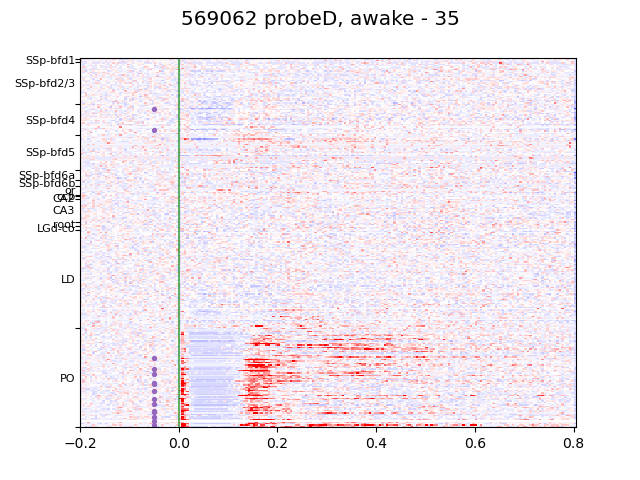

Text(0.5, 0.98, '569062 probeD, awake - 35')

In [24]:
plp = 'probeD'
set_Zrange = 10

fig, ax = plt.subplots() #, sharex=True, constrained_layout=True)

units_plot = ax.imshow(
    unit_zscores[plp][1],
    cmap='bwr',
    interpolation='none',
    aspect='auto',
    origin='lower',
    vmin=-set_Zrange,
    vmax=set_Zrange,
    extent=[unit_zscores[plp][0][0], unit_zscores[plp][0][-1], 0, len(probe_unit_data[plp]['units'])],
)
ax.axvline(0, color='g', alpha=0.6)

## plot responsive unit marker ##
responsive_units = np.argwhere(unit_pvals[plp] < 0.05).flatten()
ax.scatter(np.ones((responsive_units.shape[0]), dtype=float) * -0.05, responsive_units + 0.5, s=8, c='tab:purple')
    
if probe_unit_data[plp]['areas_assigned']:
    ## get area labels ##
    area_boundaries = []
    area_labels = []
    last_area = ''
    for ai, area in enumerate(probe_unit_data[plp]['areas']):
        if area != last_area:
            area_boundaries.append(ai)
            area_labels.append(area)
            last_area = area
    area_boundaries.append(ai)
    label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
    ax.set_yticks(area_boundaries)
    ax.set_yticklabels('')
    ax.set_yticks(label_locs, minor=True)
    ax.set_yticklabels(area_labels, minor=True, fontsize=8)
    ax.tick_params(which='minor', length=0)
else:
    unit_depths = probe_unit_data[plp]['ch_depths'][probe_unit_data[plp]['chs']]
    ax.set_yticks(np.arange(0, len(probe_unit_data[plp]['units']), 50))
    ax.set_yticklabels(unit_depths[np.arange(0, len(probe_unit_data[plp]['units']), 50)]/1000)
    ax.annotate(
        regions[plp],
        xy=(-0.12, 0.5),
        xycoords='axes fraction',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        fontsize=12
    )

plt.suptitle('{} {}, {} - {}'.format(exp.mouse, plp, plstate, plamp))

Make raster plots

In [29]:
# plp = 'probeD'
punit = 20
uniti = probe_unit_data[plp]['units'][punit]
print(uniti)

raster_long = [-0.2, 0.5]
raster_short = [-0.1, 0.1]


uniti_spikes = np.squeeze(probe_unit_data[plp]['spike_times'][probe_unit_data[plp]['spike_clusters'] == uniti])
unit_trial_raster = []
for E in state_events[rest_events]:
    spikei_inds = np.squeeze(np.argwhere((uniti_spikes > E + raster_long[0]) & (uniti_spikes < E + raster_long[1])))
    unit_trial_raster.append(uniti_spikes[spikei_inds]-E)

47


<IPython.core.display.Javascript object>


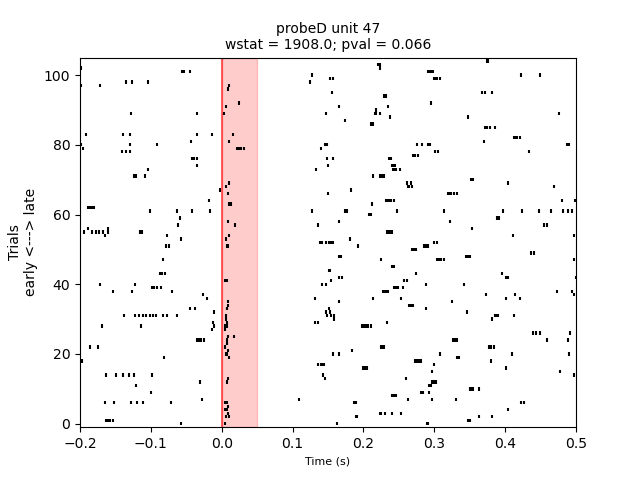

Text(0.5, 1.0, 'probeD unit 47\nwstat = 1908.0; pval = 0.066')

In [30]:
fig, ax = plt.subplots() # figsize=(5,2.5)
for indi, spikes in enumerate(unit_trial_raster):
    ax.eventplot([spikes], lineoffsets=indi, linelengths=0.95, color='black')
ax.set_xlim(raster_long)
ax.set_ylim([-1, indi+1])

## Y labels
ax.set_ylabel('Trials\nearly <---> late')

## X labels
ax.axvspan(0, 0.05, color='r', alpha=0.2)
ax.axvline(0, color='r', alpha=0.6)
ax.set_xlabel('Time (s)', fontsize=8)

ax.set_title('{} unit {}\nwstat = {:.1f}; pval = {:.3f}'.format(plp, uniti, unit_wstat[plp][punit], unit_pvals[plp][punit]))

Plot a probe: firing rate

<IPython.core.display.Javascript object>


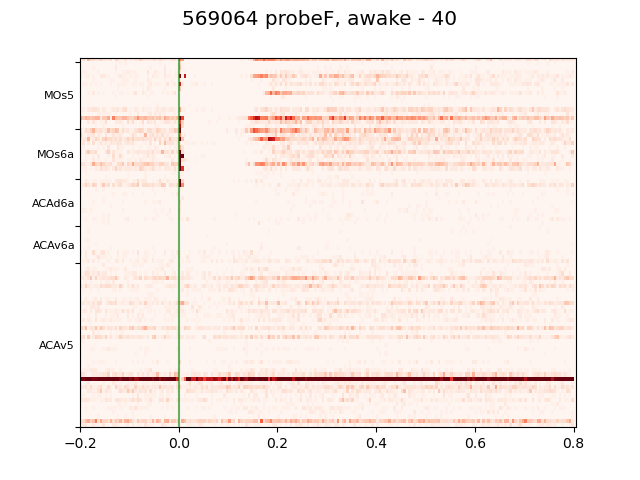

Text(0.5, 0.98, '569064 probeF, awake - 40')

In [47]:
# plp = 'probeF'
set_FRrange = 50

fig, ax = plt.subplots() #, sharex=True, constrained_layout=True)

units_plot = ax.imshow(
    unit_rates[plp][1],
    cmap='Reds',
    interpolation='none',
    aspect='auto',
    origin='lower',
    vmin=0,
    vmax=set_FRrange,
    extent=[unit_rates[plp][0][0], unit_rates[plp][0][-1], 0, len(probe_unit_data[plp]['units'])],
)
ax.axvline(0, color='g', alpha=0.6)
    
if probe_unit_data[plp]['areas_assigned']:
    ## get area labels ##
    area_boundaries = []
    area_labels = []
    last_area = ''
    for ai, area in enumerate(probe_unit_data[plp]['areas']):
        if area != last_area:
            area_boundaries.append(ai)
            area_labels.append(area)
            last_area = area
    area_boundaries.append(ai)
    label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
    ax.set_yticks(area_boundaries)
    ax.set_yticklabels('')
    ax.set_yticks(label_locs, minor=True)
    ax.set_yticklabels(area_labels, minor=True, fontsize=8)
    ax.tick_params(which='minor', length=0)
else:
    unit_depths = probe_unit_data[plp]['ch_depths'][probe_unit_data[plp]['chs']]
    ax.set_yticks(np.arange(0, len(probe_unit_data[plp]['units']), 50))
    ax.set_yticklabels(unit_depths[np.arange(0, len(probe_unit_data[plp]['units']), 50)]/1000)
    ax.annotate(
        regions[plp],
        xy=(-0.12, 0.5),
        xycoords='axes fraction',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        fontsize=12
    )

plt.suptitle('{} {}, {} - {}'.format(exp.mouse, plp, sweep_states[sweep], plamp))

## Average responses

Loop through stimuli, one sweep only

### Plot all with z-score

<IPython.core.display.Javascript object>


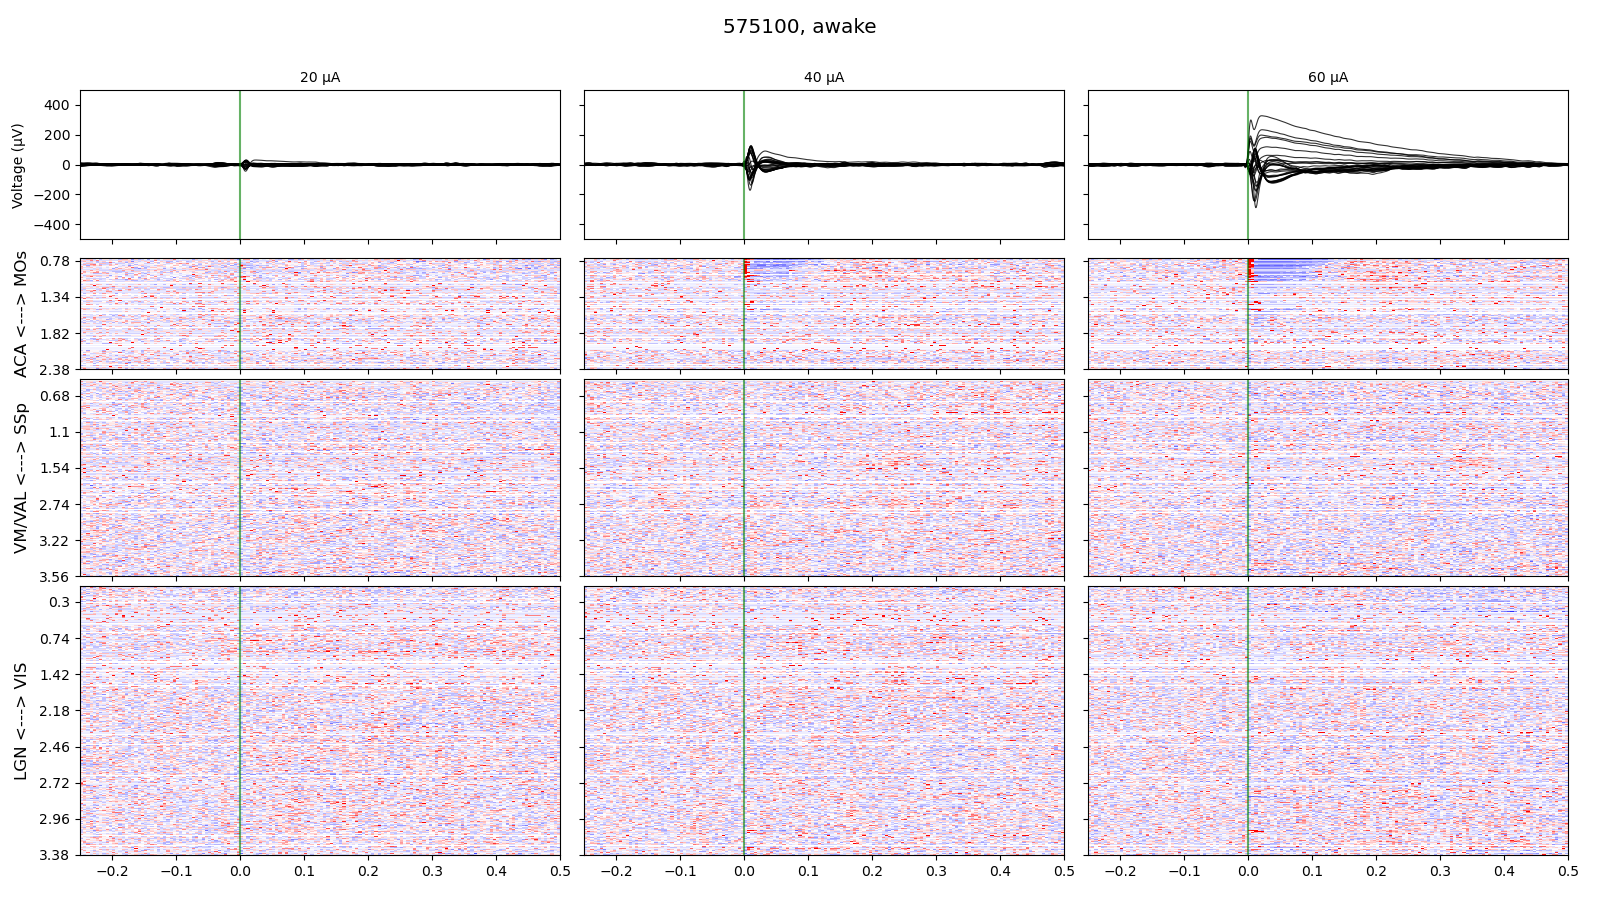

In [24]:
y_limit = 500
set_Zrange = 5

fig = plt.figure(figsize=(16,9)) #, sharex=True, constrained_layout=True)
gs = fig.add_gridspec(
    ncols=(len(amp_list)), nrows=2, height_ratios=[1,4],
    left=0.05, right=0.98, top=0.9, bottom=0.05, hspace=0.05, wspace=0.05
)

for i, ampi in enumerate(amp_list):
    ## EEG butterfly plot ##
    axeeg = fig.add_subplot(gs[0,i])
    axeeg.plot(EEG_traces[ampi][0], EEG_traces[ampi][1][:,GOOD_CHS], 'k', linewidth=0.8, alpha=0.8)
    axeeg.set_xlim([EEG_traces[ampi][0][0], EEG_traces[ampi][0][-1]])
    axeeg.set_ylim(-y_limit, y_limit)
    axeeg.axvline(0, color='g', alpha=0.6)
    axeeg.set_title('{} \u03bcA'.format(ampi))
    axeeg.set_xticklabels('')
    if i == 0:
        axeeg.set_ylabel('Voltage (\u03BCV)')
    else:
        axeeg.set_yticklabels('')

    ## Unit z-score, all probes ##
    gs_units = gs[1,i].subgridspec(
        ncols=1, nrows=len(unit_zscores[ampi].keys()),
        height_ratios=[len(probe_unit_data[x]['units']) for x in regions.keys()], hspace=0.05
    )

    for ii, probei in enumerate(regions.keys()):
        zscoredata = unit_zscores[ampi][probei]
        axzsc = fig.add_subplot(gs_units[ii])
        units_plot = axzsc.imshow(
            zscoredata[1],
            cmap='bwr',
            interpolation='none',
            aspect='auto',
            origin='lower',
            vmin=-set_Zrange,
            vmax=set_Zrange,
            extent=[zscoredata[0][0], zscoredata[0][-1], 0, len(probe_unit_data[probei]['units'])],
        )
        axzsc.axvline(0, color='g', alpha=0.6)
    
        if probe_unit_data[probei]['areas_assigned']:
            if i == 0:
                ## get area labels ##
                area_boundaries = []
                area_labels = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        area_labels.append(area)
                        last_area = area
                area_boundaries.append(ai)
                label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
                axzsc.set_yticks(label_locs, minor=True)
                axzsc.set_yticklabels(area_labels, minor=True, fontsize=8)
                axzsc.tick_params(which='minor', length=0)
            else:
                ## get area labels ##
                area_boundaries = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        last_area = area
                area_boundaries.append(ai)
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
        else:
            if i == 0:
                unit_depths = probe_unit_data[probei]['ch_depths'][probe_unit_data[probei]['chs']]
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels(unit_depths[np.arange(0, len(probe_unit_data[probei]['units']), 50)]/1000)
                axzsc.annotate(
                    regions[probei],
                    xy=(-0.12, 0.5),
                    xycoords='axes fraction',
                    horizontalalignment='center',
                    verticalalignment='center',
                    rotation='vertical',
                    fontsize=12
                )
            else:
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels('')
        if ii < len(regions)-1:
            axzsc.set_xticklabels('')
    plt.suptitle('{}, {}'.format(exp.mouse, sweep_states[sweep]))

### SAVE ###
figname = '{}_{}unitzcore_eeg_{}_allamps_{:d}ms.png'.format(exp_tag, which_units, sweep_states[sweep], int(plot_timebin*1000))
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

Loop through sweeps, one stim only

In [ ]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic', 'circle'
param = '60'
sweeps = [0, 1]

# before_event = 0.2 # time before event, s
# after_event = 0.6 # time after event, s

## EEG params ##
apply_mask = False ## already applied above
apply_car = True

## Unit params ##
plot_timebin = 0.01 # s

In [ ]:
EEG_traces = {}
unit_rates = {}
unit_zscores = {}

## Mask estim artifact ##
if apply_mask:
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]


for sweepi in sweeps:
    start = time.time()
    
    ## EEG traces ##
    events = get_stim_events(stim_log, stim_type, param, sweepi)
    eeg_event_traces, eeg_event_ts = get_evoked_traces(
        eeg_data,
        eeg_ts,
        events,
        before_event,
        after_event,
        exp.ephys_params['EEG']['sample_rate']
    )
    ## Common average reference ##
    if apply_car:
        eeg_event_traces = eeg_event_traces - np.mean(eeg_event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        
    ## Design and apply Butterworth filter ##
    filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
    EEG_traces[sweepi] = [eeg_event_ts, np.mean(signal.filtfilt(filtb, filta, eeg_event_traces, axis=0), axis=2)]
    
    
    ## Units ##
    # get evoked firing rates for all units
    unit_rates[sweepi] = {}
    unit_zscores[sweepi] = {}
    for probei, unit_data in probe_unit_data.items():
        event_trig_FR, spikerate_ts = get_evoked_firing_rates(
            unit_data['spike_times'],
            unit_data['spike_clusters'],
            unit_data['units'],
            events,
            before_event,
            after_event,
            plot_timebin
        )
        # get zscore
        event_trig_Z, non_nan_inds = get_zscore_fr(event_trig_FR, spikerate_ts)

        unit_rates[sweepi][probei] = [spikerate_ts, event_trig_FR]
        unit_zscores[sweepi][probei] = [spikerate_ts, event_trig_Z]
    
    end = time.time()
    print('sweep {}: {:.2f} s'.format(sweepi, (end - start)))

Plot all with z-score

In [ ]:
y_limit = 300
set_Zrange = 5

fig = plt.figure(figsize=(16*0.66,9)) #, sharex=True, constrained_layout=True)
gs = fig.add_gridspec(
    ncols=(len(sweeps)), nrows=2, height_ratios=[1,4],
    left=0.08, right=0.98, top=0.9, bottom=0.05, hspace=0.05, wspace=0.05
)

for i, sweepi in enumerate(sweeps):
    ## EEG butterfly plot ##
    axeeg = fig.add_subplot(gs[0,i])
    axeeg.plot(EEG_traces[sweepi][0], EEG_traces[sweepi][1][:,GOOD_CHS], 'k', linewidth=0.8, alpha=0.8)
    axeeg.set_xlim([EEG_traces[sweepi][0][0], EEG_traces[sweepi][0][-1]])
    axeeg.set_ylim(-y_limit, y_limit)
    axeeg.axvline(0, color='g', alpha=0.6)
    axeeg.set_title('{}'.format(sweep_states[sweepi]))
    axeeg.set_xticklabels('')
    if i == 0:
        axeeg.set_ylabel('Voltage (\u03BCV)')
    else:
        axeeg.set_yticklabels('')

    ## Unit z-score, all probes ##
    gs_units = gs[1,i].subgridspec(
        ncols=1, nrows=len(unit_zscores[sweepi].keys()),
        height_ratios=[len(probe_unit_data[x]['units']) for x in regions.keys()], hspace=0.1
    )

    for ii, probei in enumerate(regions.keys()):
        zscoredata = unit_zscores[sweepi][probei]
        axzsc = fig.add_subplot(gs_units[ii])
        units_plot = axzsc.imshow(
            zscoredata[1],
            cmap='bwr',
            interpolation='none',
            aspect='auto',
            origin='lower',
            vmin=-set_Zrange,
            vmax=set_Zrange,
            extent=[zscoredata[0][0], zscoredata[0][-1], 0, len(probe_unit_data[probei]['units'])],
        )
        axzsc.axvline(0, color='g', alpha=0.6)
    
        if probe_unit_data[probei]['areas_assigned']:
            if i == 0:
                ## get area labels ##
                area_boundaries = []
                area_labels = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        area_labels.append(area)
                        last_area = area
                area_boundaries.append(ai)
                label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
                axzsc.set_yticks(label_locs, minor=True)
                axzsc.set_yticklabels(area_labels, minor=True, fontsize=8)
                axzsc.tick_params(which='minor', length=0)
            else:
                ## get area labels ##
                area_boundaries = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        last_area = area
                area_boundaries.append(ai)
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
        else:
            if i == 0:
                unit_depths = probe_unit_data[probei]['ch_depths'][probe_unit_data[probei]['chs']]
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels(unit_depths[np.arange(0, len(probe_unit_data[probei]['units']), 50)]/1000)
                axzsc.annotate(
                    regions[probei],
                    xy=(-0.12, 0.5),
                    xycoords='axes fraction',
                    horizontalalignment='center',
                    verticalalignment='center',
                    rotation='vertical',
                    fontsize=12
                )
            else:
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels('')
        if ii < len(regions)-1:
            axzsc.set_xticklabels('')
    plt.suptitle('{}, {} {}'.format(exp.mouse, stim_type, str(param)))

### SAVE ###
figname = '{}_{}unitzcore_eeg_{}_awake-iso_{:d}ms.png'.format(exp_tag, which_units, param, int(plot_timebin*1000))
fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

Separate resting/running

In [ ]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic', 'circle'
param = '50'
sweeps = [0, 1]

before_event = 0.5 # time before event, s
after_event = 0.8 # time after event, s

## EEG params ##
apply_mask = False ## applied above
apply_car = True

## Unit params ##
plot_timebin = 0.01 # s

In [ ]:
EEG_traces = {}
unit_zscores = {}
trial_counts = {}

## Load running signal ##
run_signal, run_timestamps = exp.load_running()

## Mask estim artifact ##
if apply_mask:
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]


for sweepi in sweeps:
    statei = sweep_states[sweepi]
    start = time.time()
    
    ## Get events ##
    events = get_stim_events(stim_log, stim_type, param, sweepi)
    
    ## EEG traces ##
    eeg_event_traces, eeg_event_ts = get_evoked_traces(
        eeg_data,
        eeg_ts,
        events,
        before_event,
        after_event,
        exp.ephys_params['EEG']['sample_rate']
    )
    ## Common average reference ##
    if apply_car:
        eeg_event_traces = eeg_event_traces - np.mean(eeg_event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        
    ## Design and apply Butterworth filter ##
    filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
#     EEG_traces[sweepi] = [eeg_event_ts, np.mean(signal.filtfilt(filtb, filta, eeg_event_traces, axis=0), axis=2)]
    eeg_event_traces = signal.filtfilt(filtb, filta, eeg_event_traces, axis=0)
    
    if statei == 'awake':
        ## Get mean speed ##
        rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
        event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in events])
        mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
        rest_trials = np.nonzero(mean_speed < 0.5)[0]
        run_trials = np.nonzero(mean_speed >= 0.5)[0]

        EEG_traces['resting'] = [eeg_event_ts, np.mean(eeg_event_traces[:, :, rest_trials], axis=2)]
        EEG_traces['running'] = [eeg_event_ts, np.mean(eeg_event_traces[:, :, run_trials], axis=2)]
        
        ## Units ##
        unit_zscores['resting'] = {}
        unit_zscores['running'] = {}
        for probei, unit_data in probe_unit_data.items():
            ## resting ##
            rest_FR, rest_ts = get_evoked_firing_rates(
                unit_data['spike_times'],
                unit_data['spike_clusters'],
                unit_data['units'],
                events[rest_trials],
                before_event,
                after_event,
                plot_timebin
            )
            # get zscore
            rest_Z, rest_nan_inds = get_zscore_fr(rest_FR, rest_ts)
            unit_zscores['resting'][probei] = [rest_ts, rest_Z]
            ## running ##
            run_FR, run_ts = get_evoked_firing_rates(
                unit_data['spike_times'],
                unit_data['spike_clusters'],
                unit_data['units'],
                events[run_trials],
                before_event,
                after_event,
                plot_timebin
            )
            # get zscore
            run_Z, run_nan_inds = get_zscore_fr(run_FR, run_ts)
            unit_zscores['running'][probei] = [run_ts, run_Z]
            
        print('resting trials: {:d}'.format(len(rest_trials)))
        print('running trials: {:d}'.format(len(run_trials)))
        trial_counts['resting'] = len(rest_trials)
        trial_counts['running'] = len(run_trials)
    else:
        EEG_traces[statei] = [eeg_event_ts, np.mean(eeg_event_traces, axis=2)]
        
        ## Units ##
        unit_zscores[statei] = {}
        for probei, unit_data in probe_unit_data.items():
            event_trig_FR, spikerate_ts = get_evoked_firing_rates(
                unit_data['spike_times'],
                unit_data['spike_clusters'],
                unit_data['units'],
                events,
                before_event,
                after_event,
                plot_timebin
            )
            # get zscore
            event_trig_Z, non_nan_inds = get_zscore_fr(event_trig_FR, spikerate_ts)
            unit_zscores[statei][probei] = [spikerate_ts, event_trig_Z]
        print('{} trials: {:d}'.format(statei, len(events)))
        trial_counts[statei] = len(events)
    
    end = time.time()
    print('sweep {}: {:.2f} s'.format(sweepi, (end - start)))

Plot all with z-score

In [ ]:
y_limit = 100
set_Zrange = 5

fig = plt.figure(figsize=(16,9)) #, sharex=True, constrained_layout=True)
gs = fig.add_gridspec(
    ncols=(len(EEG_traces.keys())), nrows=2, height_ratios=[1,4],
    left=0.08, right=0.98, top=0.9, bottom=0.05, hspace=0.05, wspace=0.05
)

for i, statei in enumerate(EEG_traces.keys()):
    ## EEG butterfly plot ##
    axeeg = fig.add_subplot(gs[0,i])
    axeeg.plot(EEG_traces[statei][0], EEG_traces[statei][1][:,GOOD_CHS], 'k', linewidth=0.8, alpha=0.8)
    axeeg.set_xlim([EEG_traces[statei][0][0], EEG_traces[statei][0][-1]])
    axeeg.set_ylim(-y_limit, y_limit)
    axeeg.axvline(0, color='g', alpha=0.6)
    axeeg.set_title('{} (n={:d})'.format(statei, trial_counts[statei]))
    axeeg.set_xticklabels('')
    if i == 0:
        axeeg.set_ylabel('Voltage (\u03BCV)')
    else:
        axeeg.set_yticklabels('')

    ## Unit z-score, all probes ##
    gs_units = gs[1,i].subgridspec(
        ncols=1, nrows=len(unit_zscores[statei].keys()),
        height_ratios=[len(probe_unit_data[x]['units']) for x in regions.keys()], hspace=0.1
    )

    for ii, probei in enumerate(regions.keys()):
        zscoredata = unit_zscores[statei][probei]
        axzsc = fig.add_subplot(gs_units[ii])
        units_plot = axzsc.imshow(
            zscoredata[1],
            cmap='bwr',
            interpolation='none',
            aspect='auto',
            origin='lower',
            vmin=-set_Zrange,
            vmax=set_Zrange,
            extent=[zscoredata[0][0], zscoredata[0][-1], 0, len(probe_unit_data[probei]['units'])],
        )
        axzsc.axvline(0, color='g', alpha=0.6)
    
        if probe_unit_data[probei]['areas_assigned']:
            if i == 0:
                ## get area labels ##
                area_boundaries = []
                area_labels = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        area_labels.append(area)
                        last_area = area
                area_boundaries.append(ai)
                label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
                axzsc.set_yticks(label_locs, minor=True)
                axzsc.set_yticklabels(area_labels, minor=True, fontsize=8)
                axzsc.tick_params(which='minor', length=0)
            else:
                ## get area labels ##
                area_boundaries = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        last_area = area
                area_boundaries.append(ai)
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
        else:
            if i == 0:
                unit_depths = probe_unit_data[probei]['ch_depths'][probe_unit_data[probei]['chs']]
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels(unit_depths[np.arange(0, len(probe_unit_data[probei]['units']), 50)]/1000)
                axzsc.annotate(
                    regions[probei],
                    xy=(-0.12, 0.5),
                    xycoords='axes fraction',
                    horizontalalignment='center',
                    verticalalignment='center',
                    rotation='vertical',
                    fontsize=12
                )
            else:
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels('')
        if ii < len(regions)-1:
            axzsc.set_xticklabels('')
    plt.suptitle('{}, {} {}'.format(exp.mouse, stim_type, str(param)))

### SAVE ###
figname = '{}_{}unitzcore_eeg_{}_rest-run-iso.png'.format(exp_tag, which_units, param)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

### Testing

In [ ]:
all_area_bounds = {}
all_area_labels = {}
all_area_label_locs = {}
for ii, probei in enumerate(regions.keys()):
    ## get area labels ##
    area_boundaries = []
    area_labels = []
    last_area = ''
    for ai, area in enumerate(probe_unit_data[probei]['unit_area']):
        if area != last_area:
            area_boundaries.append(ai)
            area_labels.append(area)
            last_area = area
    area_boundaries.append(ai)
    label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
    
    all_area_bounds[probei] = area_boundaries
    all_area_labels[probei] = area_labels
    all_area_label_locs[probei] = label_locs

In [ ]:
print(all_area_labels['probeF'])
print(all_area_bounds['probeF'])
# man_area_labels = {}
# man_area_bounds = {}
# man_area_label_locs = {}
# man_area_labels['probeF'] = all_area_labels['probeF']
# man_area_bounds['probeF'] = all_area_bounds['probeF']
# man_area_label_locs['probeF'] = all_area_label_locs['probeF']

In [ ]:
print(all_area_labels['probeB'])
print(all_area_bounds['probeB'])
print(all_area_label_locs['probeB'])

# man_area_labels['probeB'] = ['CL', 'LD', 'DG/CA1', 'ccb', 'RSPagl']
# man_area_bounds['probeB'] = [0, 56, 96, 108, 124, 125]
# man_area_label_locs['probeB'] = [28., 76., 102., 116., 124.5]

In [ ]:
print(all_area_labels['probeC'])
print(all_area_bounds['probeC'])
print(all_area_label_locs['probeC'])

# man_area_labels['probeC'] = ['LP', 'fiber tracts', 'DG/CA1', 'fp', 'VISpm6a/b', 'VISpm5', 'VISpm2/3']
# man_area_bounds['probeC'] = [0, 138, 154, 189, 219, 233, 282, 291]
# man_area_label_locs['probeC'] = [69., 146., 171.5, 204, 226, 257.5, 286.5]

In [ ]:
## Plot woth manually corrected labels for visibility ##
y_limit = 200
set_Zrange = 5

fig = plt.figure(figsize=(16/2,12)) #, sharex=True, constrained_layout=True)
gs = fig.add_gridspec(ncols=(len(sweeps)), nrows=2, height_ratios=[1,4], left=0.1, right=0.98, hspace=0.1, wspace=0.1)

for i, sweepi in enumerate(sweeps):
    ## EEG butterfly plot ##
    axeeg = fig.add_subplot(gs[0,i])
    axeeg.plot(EEG_traces[sweepi][0], EEG_traces[sweepi][1][:,GOOD_CHS], 'k', linewidth=0.8, alpha=0.8)
    axeeg.set_xlim([EEG_traces[sweepi][0][0], EEG_traces[sweepi][0][-1]])
    axeeg.set_ylim(-y_limit, y_limit)
    axeeg.axvline(0, color='g', alpha=0.6)
    axeeg.set_title('{}'.format(sweep_states[sweepi]))
    axeeg.set_xticklabels('')
    if i == 0:
        axeeg.set_ylabel('Voltage (\u03BCV)')
    else:
        axeeg.set_yticklabels('')

    ## Unit z-score, all probes ##
    gs_units = gs[1,i].subgridspec(
        ncols=1, nrows=len(unit_zscores[sweepi].keys()),
        height_ratios=[len(probe_unit_data[x]['units']) for x in regions.keys()], hspace=0.1
    )

    for ii, probei in enumerate(regions.keys()):
        zscoredata = unit_zscores[sweepi][probei]
        axzsc = fig.add_subplot(gs_units[ii])
        units_plot = axzsc.imshow(
            zscoredata[1],
            cmap='bwr',
            interpolation='none',
            aspect='auto',
            origin='lower',
            vmin=-set_Zrange,
            vmax=set_Zrange,
            extent=[zscoredata[0][0], zscoredata[0][-1], 0, len(probe_unit_data[probei]['units'])],
        )
        axzsc.axvline(0, color='g', alpha=0.6)
        
        axzsc.set_yticks(man_area_bounds[probei])
        axzsc.set_yticklabels('')
        if i == 0:
            axzsc.set_yticks(man_area_label_locs[probei], minor=True)
            axzsc.set_yticklabels(man_area_labels[probei], minor=True, fontsize=8)
            axzsc.tick_params(which='minor', length=0)

        if ii < len(regions)-1:
            axzsc.set_xticklabels('')
        else:
            axzsc.set_xlabel('Time from stim onset (s)')
#     plt.xlabel('Time from stimulus onset (s)')
#     cbar = plt.colorbar(units_plot, ax=axzsc)
#     cbar.set_label('Firing rate (Z-score)', fontsize=12)
#     cbar.ax.tick_params(labelsize=12)
    plt.suptitle('{}, {} {}'.format(exp.mouse, stim_type, param))

### SAVE ###
figname = '{}_unitzcore_eeg_{}_awake-iso.png'.format(exp_tag, param)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

### Loop through sweeps

Set plot parameters

In [ ]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic', 'circle'
stim_amp = 100 # current amplitude, color
state_sweeps = {0: 'awake', 1: 'anesthetized'}#, 2: 'recovery1', 3: 'recovery2'}

before_event = 0.2 # time before event, s
after_event = 0.8 # time after event, s

## EEG params ##
apply_mask = True
apply_car = True

## Unit params ##
plot_timebin = 0.01 # s

In [ ]:
EEG_traces = {}
unit_rates = {}
unit_zscores = {}

## Mask estim artifact ##
if apply_mask:
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]

for sweepi, statei in state_sweeps.items():
    start = time.time()
    
    ## EEG traces ##
    events = get_stim_events(stim_log, stim_type, stim_amp, sweepi)
    eeg_event_traces, eeg_event_ts = get_evoked_traces(
        eeg_data,
        eeg_ts,
        events,
        before_event,
        after_event,
        exp.ephys_params['EEG']['sample_rate']
    )
    ## Common average reference ##
    if apply_car:
        eeg_event_traces = eeg_event_traces - np.mean(eeg_event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        
    ## Design and apply Butterworth filter ##
    filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
    EEG_traces[statei] = [eeg_event_ts, np.mean(signal.filtfilt(filtb, filta, eeg_event_traces, axis=0), axis=2)]
    
    
    ## Units ##
    # get evoked firing rates for all units
    unit_rates[statei] = {}
    unit_zscores[statei] = {}
    for probei, unit_data in probe_unit_data.items():
        event_trig_FR, spikerate_ts = get_evoked_firing_rates(
            unit_data['spike_times'],
            unit_data['spike_clusters'],
            unit_data['units'],
            events,
            before_event,
            after_event,
            plot_timebin
        )
        # get zscore
        event_trig_Z, non_nan_inds = get_zscore_fr(event_trig_FR, spikerate_ts)

        unit_rates[statei][probei] = [spikerate_ts, event_trig_FR]
        unit_zscores[statei][probei] = [spikerate_ts, event_trig_Z]
    
    end = time.time()
    print('{} time: {:.2f} s'.format(statei, (end - start)))

Plot all with z-score

In [ ]:
plot_state = 'awake' # 'awake' 'anesthetized' 'recovery1'
y_limit = 200
set_Zrange = 4

fig = plt.figure(figsize=(8,8)) #, sharex=True, constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1,3], left=0.1, right=0.98, hspace=0.1)

## EEG butterfly plot ##
axeeg = fig.add_subplot(gs[0])
axeeg.plot(EEG_traces[plot_state][0], EEG_traces[plot_state][1], 'k', linewidth=1)
axeeg.set_xlim([EEG_traces[plot_state][0][0], EEG_traces[plot_state][0][-1]])
axeeg.set_ylim(-y_limit, y_limit)
axeeg.axvline(0, color='g')
axeeg.set_ylabel('Voltage (\u03BCV)', fontsize=12)
axeeg.set_xticklabels('')

## Unit z-score, all probes ##
# gs_units = gs[1].subgridspec(ncols=1, nrows=len(unit_zscores[plot_state].keys()), height_ratios=[len(probe_unit_data[x]['units']) for x in probe_unit_data.keys()], hspace=0.1)
gs_units = gs[1].subgridspec(ncols=1, nrows=len(unit_zscores[plot_state].keys()), height_ratios=[len(probe_unit_data[x]['units']) for x in regions.keys()], hspace=0.1)
# for ii, (probei, zscoredata) in enumerate(unit_zscores[plot_state].items()):
for ii, probei in enumerate(regions.keys()):
    zscoredata = unit_zscores[plot_state][probei]
    axzsc = fig.add_subplot(gs_units[ii])
    units_plot = axzsc.imshow(
        zscoredata[1],
        cmap='bwr',
        interpolation='none',
        aspect='auto',
        origin='lower',
        vmin=-set_Zrange,
        vmax=set_Zrange,
        extent=[zscoredata[0][0], zscoredata[0][-1], 0, len(probe_unit_data[probei]['units'])],
    )
    axzsc.axvline(0, color='g')
    
    plt.tick_params(axis='y', left=False, labelleft=False)
    axzsc.annotate(
        regions[probei],
        xy=(-0.02, 0.5),
        xycoords='axes fraction',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        fontsize=12
    )
# plt.xlabel('Time from stimulus onset (s)')
# cbar = plt.colorbar(units_plot, ax=axzsc)
# cbar.set_label('Firing rate (Z-score)', fontsize=12)
# cbar.ax.tick_params(labelsize=12)
plt.suptitle('{}: {}, {}'.format(exp.mouse, plot_state, stim_amp))
### SAVE ###
# fig.savefig(os.path.join(plotsavedir, 'earlyUR_estim_EEG_raster_EP.png'), transparent=True)

## Old, haven't corrected yet

### Plot single trial (stim or spontaneous)

In [ ]:
plot_before = 0.5 # time before event, s
plot_after = 1.0 # time after event, s
plot_event = 'stim' # 'spont' or 'stim'

## if plot_event == 'spont'
spont_time = 5671. # time in s to plot around if spont is chosen

## if plot_event == 'stim'
event_ind = 85 # stim_event time to choose, must be integer
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
stim_amp = 60 # current amplitude = [20, 50, 70, 100]
stim_sweep = 0 # look at an event during chosen sweep, int between 0 and 9?

In [ ]:
if plot_event == 'spont':
    plot_time = spont_time # this value should be in seconds
elif plot_event == 'stim':
    stim_times = get_stim_events(stim_log, stim_type, stim_amp, stim_sweep)
    plot_time = stim_times[event_ind] # this value should be in seconds
print('Plot time: {:.2f} s'.format(plot_time))

### Raster plot for units

In [ ]:
units_raster = {}
for probei, unit_data in probe_unit_data.items():
    units_raster[probei] = []
    for uniti in unit_data['units']:
        spikesi = np.squeeze(unit_data['spike_times'][unit_data['spike_clusters'] == uniti])
        spikei_inds = np.squeeze(np.argwhere((spikesi > plot_time-plot_before) & (spikesi < plot_time+plot_after)))
        units_raster[probei].append(spikesi[spikei_inds])

#### Plot raster

In [ ]:
turn_on_xlabels = True
# ylabel_depth = True

fig, ax = plt.subplots() # figsize=(5,2.5)
ii = 0
for probei in probe_plot_order:
    unit_data = probe_unit_data[probei]
    
    for indi, spikes in enumerate(units_raster[probei]):
        ax.eventplot([spikes], lineoffsets=indi+ii, linelengths=0.95, color='black')
    ax.axhline(indi + ii + 1)
    ax.annotate(
        regions[probei],
#         '{:s}\nventral <-> dorsal'.format(regions[probei]),
        xy=(0, np.mean([ii, indi+ii])),
        xycoords='axes points',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical'
    )
    ii = indi + ii + 2

## Y labels
ax.axhline(-1)
ax.set_ylim([-2, ii+1])
plt.tick_params(axis='y', left=False, labelleft=False)

## X labels
ax.set_xlim([plot_time-plot_before, plot_time+plot_after])
if plot_event == 'stim':
    ax.axvline(plot_time, color='r', alpha=0.8)
if turn_on_xlabels:
    if plot_event == 'stim':
        ax.set_xticks(np.arange(plot_time-plot_before, plot_time+plot_after, 0.25))
        ax.set_xticklabels(np.arange(-plot_before, plot_after, 0.25), fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_xlabel('Time (s)', fontsize=8)
else:
    plt.tick_params(axis='x', labelbottom=False)

### EEG plot all channels

In [ ]:
if plot_event == 'spont':
    plot_inds = np.squeeze(np.argwhere((eeg_ts > plot_time-plot_before) & (eeg_ts < plot_time+plot_after)))
    eeg_traces = eeg_data[plot_inds, :]
    eeg_xaxis = eeg_ts[plot_inds]
elif plot_event == 'stim':
    plot_inds = np.squeeze(np.argwhere((eeg_ts > plot_time-plot_before) & (eeg_ts < plot_time+plot_after)))
    eeg_traces = eeg_data[plot_inds, :]
    eeg_xaxis = eeg_ts[plot_inds] - plot_time

Filter the EEG with FIR filter, lowpass @ 200 Hz

In [ ]:
## FIR filter ##
# design and check the lowpass filter kernel
filter_kernel_eeg = lowpass_filt_design(len(eeg_xaxis),
                                    exp.ephys_params['EEG']['sample_rate'],
                                    cutoff_freq=200,
                                    trans_width=0.2,
                                    order_multiple=11,
                                    plot_kern=False)
eeg_lowpass = signal.filtfilt(filter_kernel_eeg, 1, eeg_traces, axis=0)

Plot voltage traces from all chs

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sep = 300

for chind in eeg_chs:
    ax.plot(eeg_xaxis, eeg_lowpass[:,chind]+sep*chind, 'k', linewidth=0.8)

ax.annotate(
    '',
    xy=(-.03, 0), xycoords='axes fraction',
    xytext=(-.03, 1000/(sep*(chind+1.5) - (-sep*1.5))), textcoords='axes fraction',
    arrowprops=dict(arrowstyle='-'),
    horizontalalignment='center', verticalalignment='center', rotation='vertical'
)
ax.annotate(
    '1 mV',
    xy=(-.05, 500/(sep*(chind+1.5) - (-sep*1.5))), xycoords='axes fraction',
    horizontalalignment='center', verticalalignment='center', rotation='vertical'
)

ax.set_xlim([eeg_xaxis[0], eeg_xaxis[-1]])
ax.set_ylim([-sep*1.5, sep*(chind+1.5)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG electrode #\nleft <--> right hemisphere')
ax.set_title('EEG data')
ax.get_yaxis().tick_left()
plt.yticks(range(0, sep*(chind+1), sep), eeg_chs, fontsize=6)

plt.show()

### Plot EEG and raster together

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8,5), sharex=True, constrained_layout=True)

## Plot EEG on top ##
sep = 300
for chind in eeg_chs:
    axs[0].plot(eeg_xaxis, eeg_lowpass[:,chind]+sep*chind, 'k', linewidth=0.8)
axs[0].set_xlim([eeg_xaxis[0], eeg_xaxis[-1]])
axs[0].set_ylim([-sep*1.5, sep*(chind+1.5)])
axs[0].set_yticks([np.mean([-sep*1.5, sep*(chind+1.5)])])
axs[0].set_yticklabels([])
# axs[0].set_ylabel('EEG\nleft <-> right')
axs[0].annotate(
    'EEG signals\nleft <-> right',
    xy=(-0.03, 0.5),
    xycoords='axes fraction',
    horizontalalignment='center',
    verticalalignment='center',
    rotation='vertical',
    fontsize=12
)

# add scale bar #
axs[0].annotate(
    '',
    xy=(-.01, (sep*1.5)/(sep*(chind+1.5) - (-sep*1.5))), xycoords='axes fraction',
    xytext=(-.01, (sep*1.5+1000)/(sep*(chind+1.5) - (-sep*1.5))), textcoords='axes fraction',
    arrowprops=dict(arrowstyle='-'),
    horizontalalignment='center', verticalalignment='center', rotation='vertical'
)
axs[0].annotate(
    '1 mV',
    xy=(-.02, (sep*1.5+500)/(sep*(chind+1.5) - (-sep*1.5))), xycoords='axes fraction',
    horizontalalignment='center', verticalalignment='center', rotation='vertical', fontsize=12
)

## Plot rasters ##
ii = 0
for probei in probe_plot_order:
    for indi, spikes in enumerate(units_raster[probei]):
        axs[1].eventplot([spikes], lineoffsets=indi+ii, linelengths=0.95, color='black')
    axs[1].axhline(indi + ii + 1)
    axs[1].annotate(
        regions[probei],
        xy=(-0.02, np.mean([ii, indi+ii])/total_units),
        xycoords='axes fraction',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        fontsize=12
    )
    ii = indi + ii + 2

## Y labels
axs[1].axhline(-1)
axs[1].set_ylim([-2, ii+1])
plt.tick_params(axis='y', left=False, labelleft=False)
axs[1].annotate(
    'All units spike raster',
    xy=(-0.04, 0.5),
    xycoords='axes fraction',
    horizontalalignment='center',
    verticalalignment='center',
    rotation='vertical',
    fontsize=12
)

## X labels
if plot_event == 'stim':
    axs[1].axvline(plot_time, color='r', alpha=0.8)
if turn_on_xlabels:
    if plot_event == 'stim':
        axs[1].set_xticks(np.arange(plot_time-plot_before, plot_time+plot_after, 0.25))
        axs[1].set_xticklabels(np.arange(-plot_before, plot_after, 0.25), fontsize=12)
    axs[1].tick_params(axis='x', labelsize=12)
    axs[1].set_xlabel('Time (s)', fontsize=12)
else:
    plt.tick_params(axis='x', labelbottom=False)
    
### SAVE ###
# fig.savefig(os.path.join(plotsavedir, 'urethane2_spont_EEG_raster_10s_5671.png'), transparent=True)